In [1]:
#imports
import numpy as np
import os
import cv2
import sys
import matplotlib.pyplot as plt
%matplotlib inline

#load image and make necesssary transformations
img = cv2.imread('Package_01_synthetic_3_4_im.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (640, 480),interpolation=cv2.INTER_NEAREST)
print('RGB image shape:', img.shape)
img = img/4
image = img.astype(np.uint8)
print('length of image shape:', len(img.shape))

RGB image shape: (480, 640, 3)
length of image shape: 3


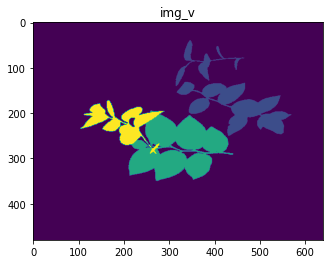

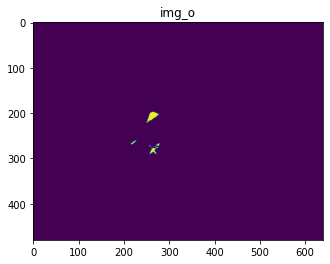

In [2]:
#show the visible instances from the second chanel.
img_v= image[:,:,2] #visible instances.
plt.imshow(img_v)
plt.title('img_v')
plt.show()

#show the occluded mask from the 0 chanel.
img_o= image[:,:,0] #occluded segment from an instance.
plt.imshow(img_o)
plt.title('img_o')
plt.show()

In [3]:
"""
Masks with labels begining with 3 such as 31 or 32, are for occluded instances,i.e.
part of the instance is occluded. On the contrary, labels starting with 5, such as 
51 or 52 are for visible instances, i.e. it is fully visible.
"""
"""
TODO: Why are there 31, and 32 labels in the visible mask, despite being listed in occluded labels list?

Answer: Because the 31 and 32 labels correspond to instances. Part of those instances are visible,
and the visible parts of them are shown below..
"""
def get_visible_labels(img_v):
    # Histogram calculation is needed for labels calculation.
    hist_v = cv2.calcHist([img_v], [0], None, [256], [0, 256])
    #print('Type of hist_v is :', type(hist_v))
    #plt.plot(hist_v, color='r')
    #plt.title('hist_v')
    #plt.show()
    # https://www.pyimagesearch.com/2021/04/28/opencv-image-histograms-cv2-calchist/
    labels_v = []
    [labels_v.append(i) for i, l in enumerate(hist_v) if i!= 0 and l != 0]
    #print('Type of labels_v is :', type(labels_v))
    return labels_v


def get_occluded_labels(img_o):
    hist_o = cv2.calcHist([img_o], [0], None, [256], [0, 256])
    #print('Type of hist_o is :', type(hist_o))
    #plt.plot(hist_o, color='b')
    #plt.title('hist_o')
    #plt.show()
    labels_o = []
    [labels_o.append(i) for i, l in enumerate(hist_o) if i!= 0 and l != 0]
    #print('Type of labels_o is :', type(labels_o))
    return labels_o

In [4]:
labels_v = get_visible_labels(img_v)
print('visible labels are: ',labels_v)
np.save('labels_v', labels_v)
labels_o = get_occluded_labels(img_o)
print('occluded labels are: ', labels_o)
np.save('labels_o', labels_o)

visible labels are:  [11, 12, 31, 51]
occluded labels are:  [31]


In [5]:
def get_repeated_instances(labels_v, labels_o):
    repeated_instances = []
    for i in labels_v:
        if i in labels_o:
            repeated_instances.append(i)
    return repeated_instances

In [6]:
repeated_instances = get_repeated_instances(labels_v, labels_o)
print('repeated instances: ', repeated_instances)

repeated instances:  [31]


In [43]:
def create_mask_instances_dic(labels_v,img_v, img_o, repeated_instances):
    #make a dictionary containing pairs of instance label (key) and instance mask (value). 
    dic_instances_masks = {}
    for instance_id in labels_v:
        if instance_id in repeated_instances:
            # combine visible and occluded parts of an instance into one mask.
            mask_o = img_o == instance_id # mask_o = 1 when condition is True, = 0 False.
            print(mask_o.dtype) # : bool
            mask_o = mask_o.astype(np.uint8)
            mask_v = img_v == instance_id
            mask_v = mask_v.astype(np.uint8)
            mask = mask_v + mask_o*2
            # Applies the mask to the original image, expect binary values: 0,1 only! ((((CHECK!!!))))
            dic_instances_masks[instance_id] = cv2.bitwise_and(img_v, img_v, mask=mask * 255)
            #print(np.max(dic_instances_masks[instance_id]))

        else:    
            #create mask for each instance id in the labels list.
            mask = img_v == instance_id # assign 1 to pixels which have instance_id intensity value, 0 otherwise.
            #print(mask.dtype) : bool
            mask = mask.astype(np.uint8)
            # Applies the mask to the original image, expect binary values: 0,1 only! ((((CHECK!!!))))
            # dictionary[key] = value
            dic_instances_masks[instance_id] = cv2.bitwise_and(img_v, img_v, mask=mask * 255)
            #print(np.max(dic_instances_masks[instance_id]))
    print(mask_o)
    print(mask_o.shape)
    print(mask_o.dtype)
    print(type(mask_o))
    print(np.max(mask_o))
    print(np.min(mask_o))

    print(np.max(mask_v))
    print(np.min(mask_v))
    
    print(np.max(mask))
    print(np.min(mask))

    return dic_instances_masks

In [44]:
dic_instances_masks = create_mask_instances_dic(labels_v,img_v, img_o, repeated_instances)
print('keys of instances_masks:  ', dic_instances_masks.keys())

bool
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(480, 640)
uint8
<class 'numpy.ndarray'>
1
0
1
0
1
0
keys of instances_masks:   dict_keys([11, 12, 31, 51])


In [40]:
def list_of_arrays(dic_instances_masks):
    #create list of arrays (list of instances masks) for every image in the dataset
    masks_list = []
    for key in dic_instances_masks:
        mask_instance = dic_instances_masks[key]
        #masks_list = np.append(masks_list, mask_instance)
        masks_list.append(mask_instance)
    
    print(mask_instance.shape)
    print(mask_instance.dtype)
    print(type(mask_instance))
    print(np.max(mask_instance))
    print(np.min(mask_instance))
    print('.')
    print('\n\n')

    return masks_list

In [41]:
masks_list = list_of_arrays(dic_instances_masks)
print(masks_list)
print('\n\n')
#print(masks_list.shape)
print(masks_list[0])

(480, 640)
uint8
<class 'numpy.ndarray'>
51
0
.



[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)]



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0

11
<class 'list'>


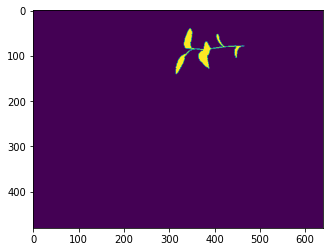

In [11]:
plt.imshow(masks_list[0]) # mask array is of numpy darrays
print(np.max(masks_list[0])) # 0 is background (purple), 1 is visible (green),
# 2 for occluded part (yello). visualize-better on matplotlib in pycharm to double-check. (confirmed).
print(type(masks_list))

12
<class 'list'>


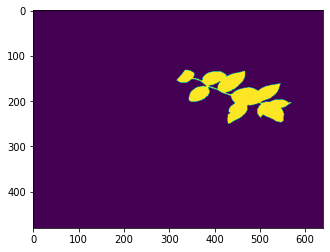

In [12]:
plt.imshow(masks_list[1]) # mask array is of numpy darrays
print(np.max(masks_list[1])) # 0 is background (purple), 1 is visible (green),
# 2 for occluded part (yello). visualize-better on matplotlib in pycharm to double-check. (confirmed).
print(type(masks_list))

51
<class 'list'>


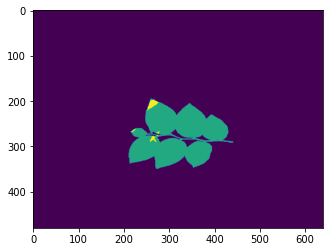

In [13]:
plt.imshow(masks_list[2]) # mask array is of numpy darrays
print(np.max(masks_list[2])) # 0 is background (purple), 1 is visible (green),
# 2 for occluded part (yello). visualize-better on matplotlib in pycharm to double-check. (confirmed).
print(type(masks_list))

51
(480, 640)
<class 'list'>


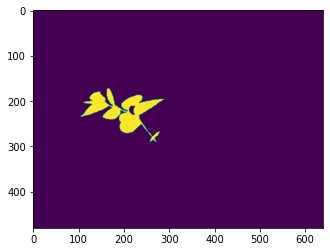

In [14]:
plt.imshow(masks_list[3]) # mask array is of numpy darrays
print(np.max(masks_list[3])) # 0 is background (purple), 1 is visible (green),
print(masks_list[0].shape)
# 2 for occluded part (yello). visualize-better on matplotlib in pycharm to double-check. (confirmed).
print(type(masks_list))

In [15]:
for key in dic_instances_masks:
    #Get bboxes
    x, y, z, w = cv2.boundingRect(dic_instances_masks[key])
    print (x, y, z, w)

315 40 151 101
317 132 253 119
211 195 231 155
105 172 185 118


In [16]:
def get_bboxes(dic_instances_masks):
    #Iterate over the keys to get bboxes:
    bboxes = []
    print(type(bboxes))
    bbox_list = []
    for key in dic_instances_masks:
        #Get bboxes
        x, y, z, w = cv2.boundingRect(dic_instances_masks[key])
        bbox_list = [x, y, z, w]
        #bbox_array = np.asarray(bbox_list)
        #print('print bbox_array:  ', bbox_array)
        #print('print bbox_array type:', type(bbox_array))
        #bboxes = np.append(bboxes, bbox_array)
        bboxes.append(bbox_list)
    bboxes = np.asarray(bboxes)
    print(type(bboxes))
    return bboxes

In [17]:
bboxes = get_bboxes(dic_instances_masks)
print(bboxes)
print(bboxes[0])

<class 'list'>
<class 'numpy.ndarray'>
[[315  40 151 101]
 [317 132 253 119]
 [211 195 231 155]
 [105 172 185 118]]
[315  40 151 101]


In [ ]:
bbox_list = []
for key, val in dic_instances_masks.items():
    x,y,z,w = cv2.boundingRect(val)
    bbox_list.append([x,y,z,w])

In [ ]:
bbox_list

In [ ]:
#Iterate over the keys to show masks:
def show_masks(instances_masks):
    for key in instances_masks:
        #show masks
        plt.imshow(instances_masks[key])
        plt.title('instance')
        plt.show()
show_masks(instances_masks)

In [ ]:
def get_instances_list(instances_masks_v):
    keys_list = []
    for key in instances_masks_v.keys():
        keys_list.append(key)
    return v_keys_list

v_keys_list = get_instances_list(instances_masks_v)
print(v_keys_list)
print(len(v_keys_list))

img_height, img_width, img_channels = img.shape
print(img_channels)
print(img_width)
print(img_height)

In [ ]:
masks_array= np.array([len(v_keys_list), img_height, img_width], dtype=np.int8)
print(len(masks_array))
print(masks_array.shape)

In [ ]:
for i, key in enumerate(v_keys_list):
    print(i, key)
    masks_array[i, :, :] = instances_masks_v[key]
print(masks_array.shape)

In [ ]:
'''
I may have to resize my dataset image to be of the following size:
masks (number of instances masks, width = 480, height = 640).
'''

In [ ]:
#create in masks.npy one mask image for all instances. DO THAT ONLY WITH VISBLE INSTANCES. THAT COVERS ALL(???).
mask = img_v == instance_id # assign 1 to pixels which have instance_id intensity value, 0 otherwise.
instances_masks_v[instance_id] = cv2.bitwise_and(img_v, img_v, mask=mask * 255)
[labels_o.append(i) for i, l in enumerate(hist_o) if i!= 0 and l != 0]
instances_masks_v = {}
for instance_id in labels_v:

In [ ]:
instances_masks_o = {}

for instance_id in labels_o:
    mask = img_o == instance_id # assign 1 to pixels which have instances_id intensity value, 0 otherwise.
    #print(mask.dtype) : bool
    mask = mask.astype(np.uint8)
    # Applies the mask to the original image, expect binary values: 0,255 only!
    instances_masks_o[instance_id] = cv2.bitwise_and(img_o, img_o, mask=mask * 255)
    #instances_masks[instance_id] = mask
print(instances_masks_o.keys())


#Iterate over the keys to show masks and get bboxes:
for key in instances_masks_o:
    #Get masks
    plt.imshow(instances_masks_o[key])
    plt.title('instance_o')
    plt.show()
    #Get bboxes
    x, y, z, w = cv2.boundingRect(instances_masks_o[key])
    print(x, y ,z, w)

In [ ]:
# 1) intesity difference b/w the visible and occluded masks in the relook architecture.
# 2) what happens when 2 instances of the same class exist in the same image. 
#    How do you distinguish b/w them in the labels? Do they even distinguish between them?

# dictionary[key] = value
#dict_keys([11, 12, 21, 22, 23, 31, 51])
print(instances_masks_v.keys())
"""
if any instance_id in instance_masks_v is repeated in instance_masks_o,
this means that the corresponding instance is occluded,
then we should multiply the occluded parts by 2 when merging all masks in the same image (masks.npy).
"""
    
mask =  instances_masks_o[31]*2 + instances_masks_v[31]

print(np.max(mask))
plt.imshow(mask)
plt.show()

In [ ]:
#This is redundant, as the occluded instances are already in the visible list.

# combine, ignore repeated:
v_o_list = v_keys_list + list(set(o_keys_list) - set(v_keys_list))
print(v_o_list)

In [ ]:
# go over the two dictionaries, for any repeated key, multiply the corresponding vlaue (occluded instance mask)
# in occluded dict. by 2, and do nothing with the visible dict.
# then add all the visible and occluded instance to one masks.npy (similar to the original daatset GT)

In [ ]:
label = list(instances_masks_v.keys())
print(label)

In [ ]:
masks = list(instances_masks_v.values())
masks = np.array(masks)
print(masks)

In [ ]:
plt.imshow(masks[0]) # mask array is tuple of numpy darrays
print(masks.dtype)
print(type(masks))